In [19]:
# This notebook shows an example of how to decode the data in the EvAAL API format to pandas DataFrame.
# Please note that the format of the txt file in ../trials/ is what returned through EvAAL API in the competition.
# In the real competition in September, you need to get data throught EvAAL API.
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sub import estimate
from scipy.spatial.transform import Rotation as R
from PIL import Image

plt.matplotlib.pyplot.rcParams['figure.figsize'] = (16.0, 6.0)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)




In [20]:
LOG_FILE_PATH = "../trials/4_1_51.txt"
GIS_BASE_PATH = "../gis/"
BEACON_LIST_PATH = GIS_BASE_PATH + "beacon_list.csv"
FLOOR_NAMES = ["FLU01", "FLU02", "FLD01"]

In [21]:

from collections import defaultdict

# Prepare containers for the data
data = defaultdict(list)

with open(LOG_FILE_PATH) as f:
    for line in f:
        line_contents = line.rstrip('\n').split(';')
        DATA_TYPE = line_contents[0]

        if DATA_TYPE == 'BLUE':
            data['BLUE'].append({
                'ts': float(line_contents[1]),
                'bdaddress': line_contents[2],
                'rssi': int(line_contents[4])
            })

        elif DATA_TYPE in ['ACCE', 'GYRO', 'MAGN']:
            record = {
                'ts': float(line_contents[1]),
                'accuracy': int(line_contents[6]),
                'x': float(line_contents[3]),
                'y': float(line_contents[4]),
                'z': float(line_contents[5])
            }
            data[DATA_TYPE].append(record)
        
        elif DATA_TYPE == 'POS3':
            data['POS3'].append({
                '%time': float(line_contents[1]),
                'x': float(line_contents[3]),
                'y': float(line_contents[4]),
                'z': float(line_contents[5]),
                'q0': float(line_contents[6]),
                'q1': float(line_contents[7]),
                'q2': float(line_contents[8]),
                'q3': float(line_contents[9]),
                'floor': line_contents[10]
            })

# Convert lists of dictionaries to dataframes
blescans = pd.DataFrame(data['BLUE'])
acc = pd.DataFrame(data['ACCE'])
gyro = pd.DataFrame(data['GYRO'])
mgf = pd.DataFrame(data['MAGN'])
gt_ref = pd.DataFrame(data['POS3'])

acc.reset_index(inplace=True, drop=True)
gyro.reset_index(inplace=True, drop=True)
mgf.reset_index(inplace=True, drop=True)
gt_ref.reset_index(inplace=True, drop=True)



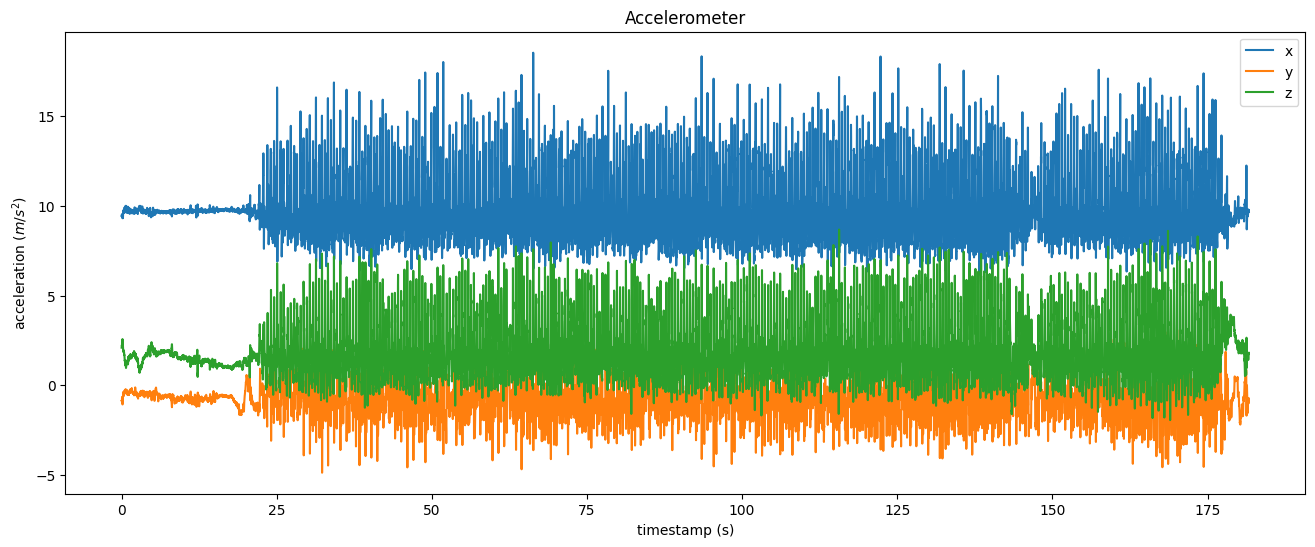

In [22]:
plt.plot(acc.ts, acc[["x", "y", "z"]], label=["x", "y", "z"])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer")
plt.legend()
plt.show()


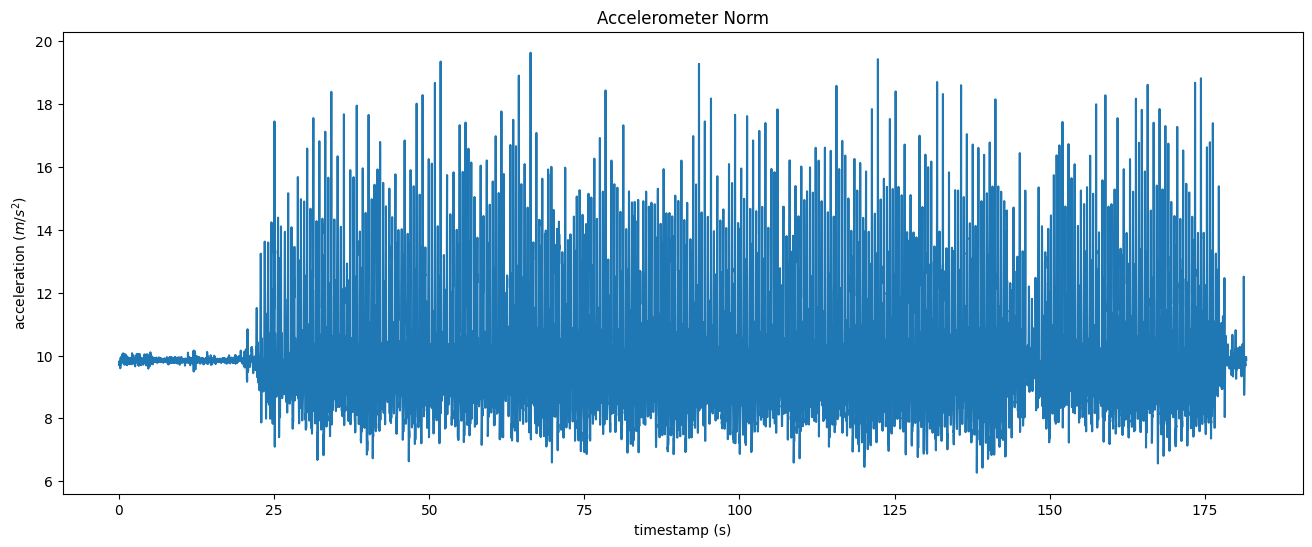

In [23]:

acc['norm'] = np.sqrt(acc['x']**2+acc['y']**2+acc['z']**2)
acc.reset_index()

plt.plot(acc.ts, acc['norm'])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

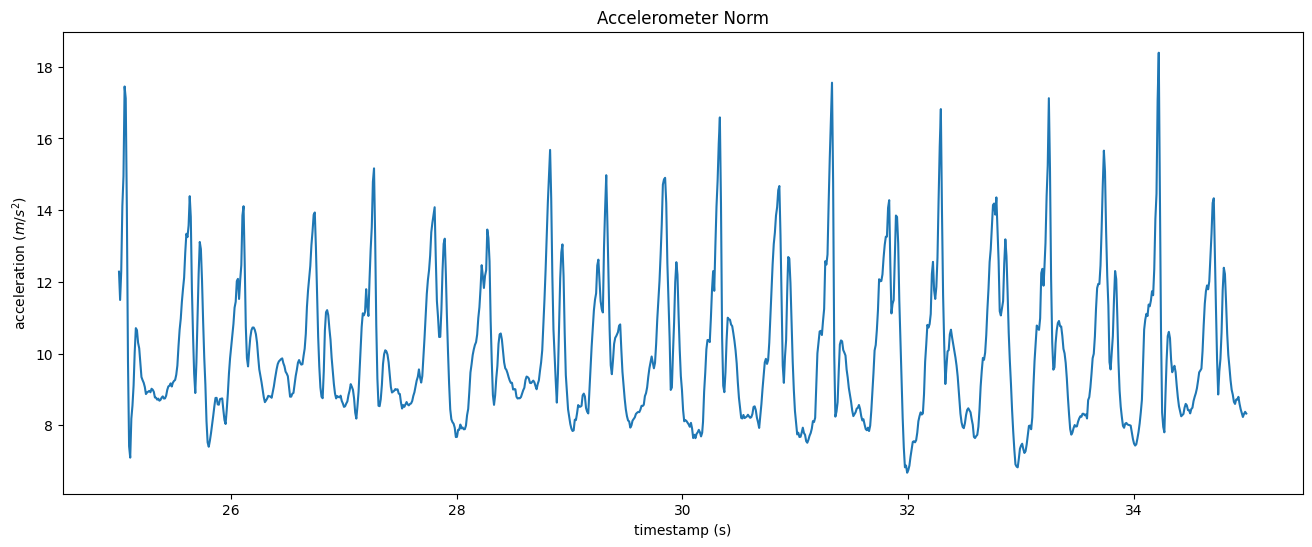

In [24]:

acc['norm'] = np.sqrt(acc['x']**2+acc['y']**2+acc['z']**2)

# 時間が25秒以上50秒未満のデータを抽出
time_filter_acc = acc[(acc.ts >= 25) & (acc.ts < 35)]
time_filter_acc.reset_index(inplace=True, drop=True)

plt.plot(time_filter_acc.ts, time_filter_acc['norm'])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

/var/folders/9p/p2bfdpzj5v5fs4xvn07kwlww0000gn/T/ipykernel_73459/170683450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filter_acc.loc[:, 'rolling_norm'] = time_filter_acc['norm'].rolling(


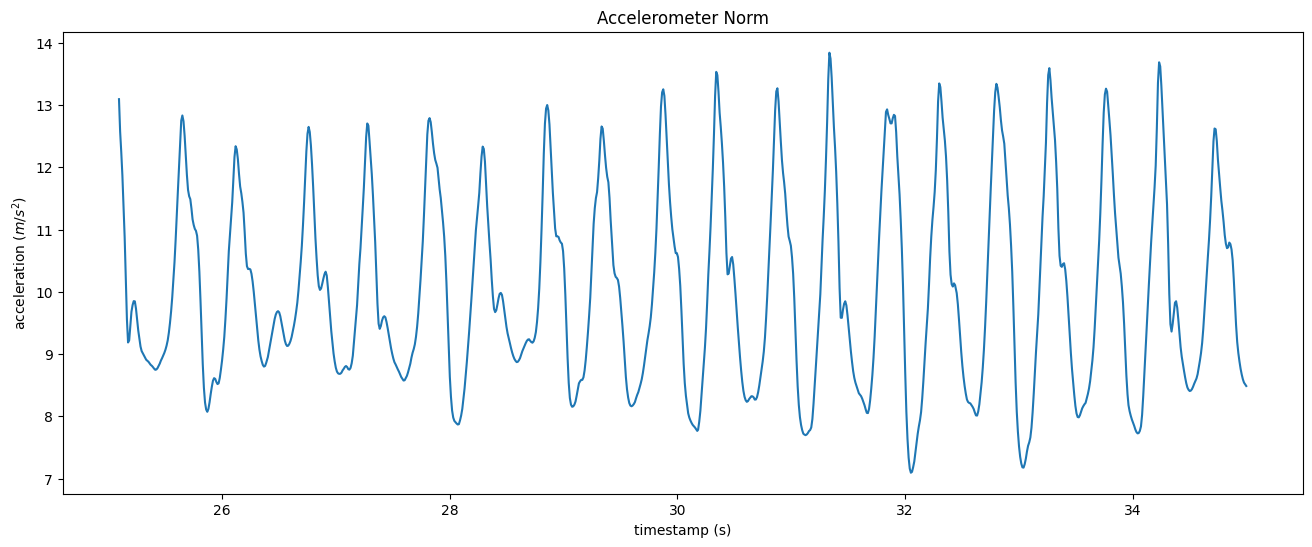

In [25]:

# 移動平均フィルターをかける
time_filter_acc.loc[:, 'rolling_norm'] = time_filter_acc['norm'].rolling(
    10).mean()

plt.plot(time_filter_acc.ts, time_filter_acc['rolling_norm'])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

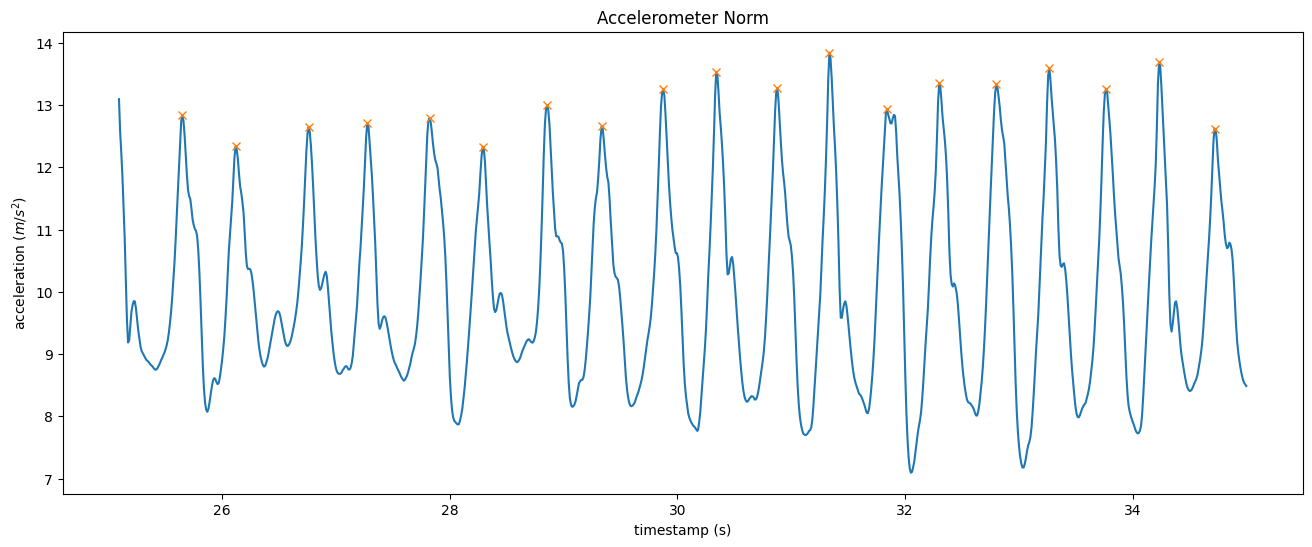

In [26]:
# ピーク検出
from scipy.signal import find_peaks

peaks, _ = find_peaks(time_filter_acc['rolling_norm'], height=12, distance=10)
plt.plot(time_filter_acc.ts, time_filter_acc['rolling_norm'])
plt.plot(time_filter_acc.ts[peaks],
         time_filter_acc['rolling_norm'][peaks], "x")
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()


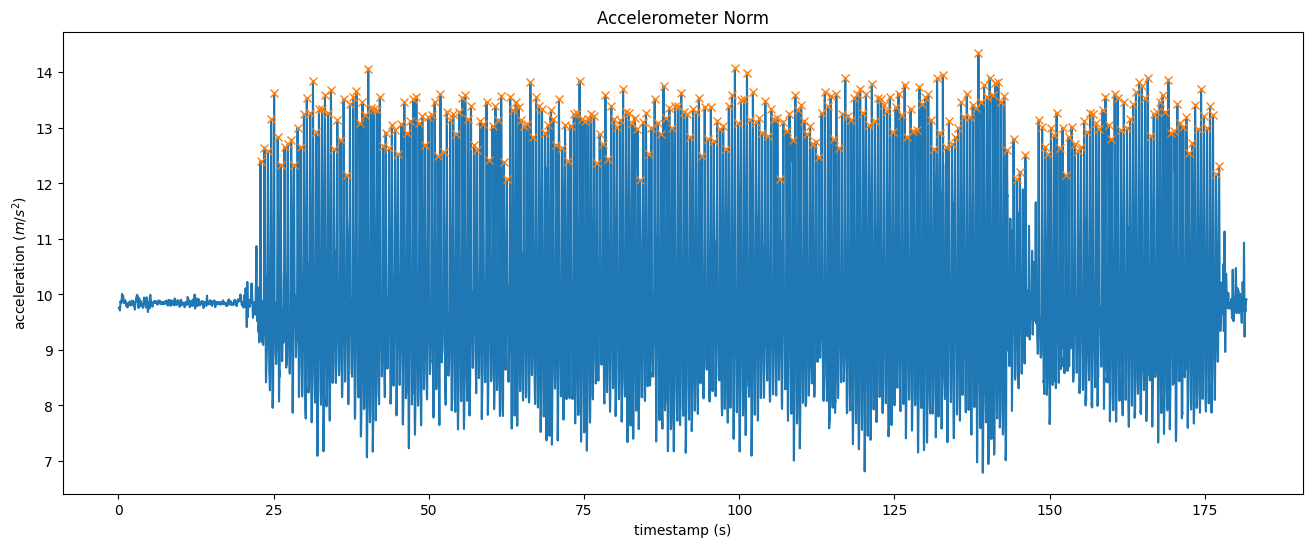

In [27]:

acc['rolling_norm'] = acc['norm'].rolling(10).mean()

peaks, _ = find_peaks(acc['rolling_norm'], height=12, distance=10)
plt.plot(acc.ts, acc['rolling_norm'])
plt.plot(acc.ts[peaks], acc['rolling_norm'][peaks], "x")
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()



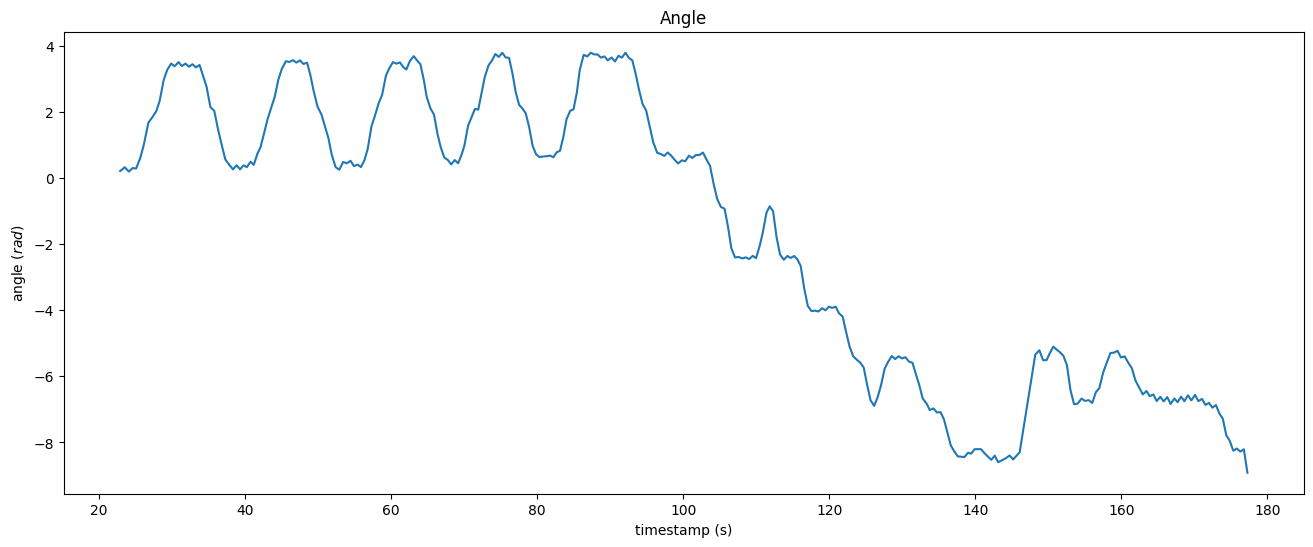

In [28]:


gyro_in_step_timing = pd.DataFrame()
gyro_in_step_timing = estimate.match_data(gyro, acc.ts[peaks])


# ジャイロを積分して角度に変換
angle_in_step_timing = pd.DataFrame()
angle_in_step_timing= estimate.convert_to_peek_angle(gyro, acc, peaks)

plt.plot(angle_in_step_timing.ts, angle_in_step_timing['x'])
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()


FLU01


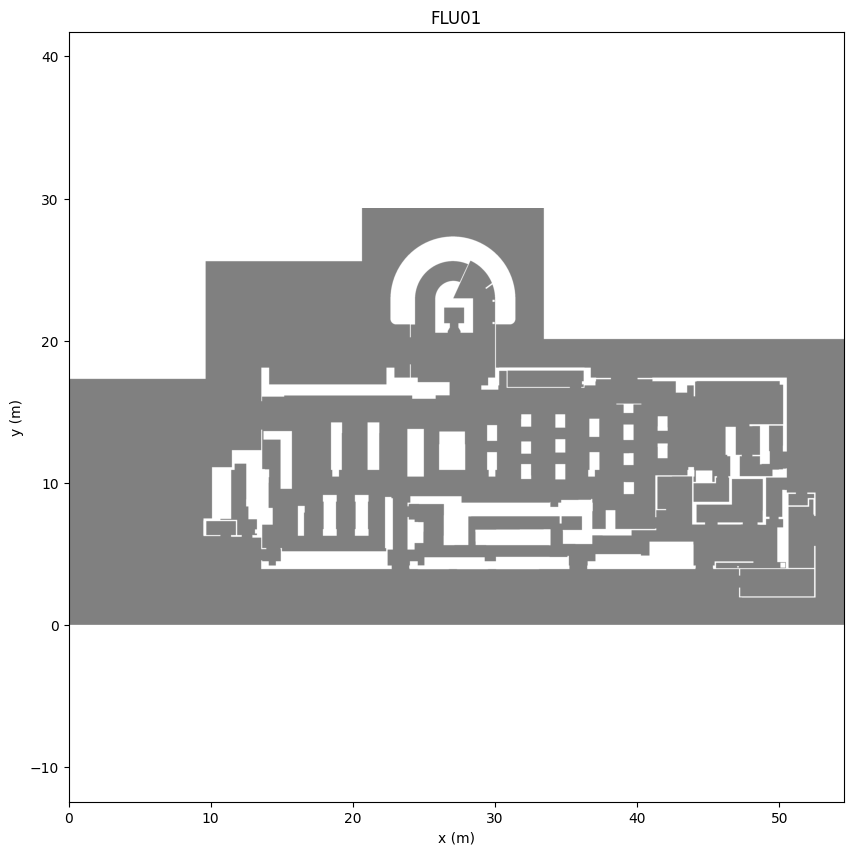

In [29]:
# 1 pixel of bmp represents 0.01 m
dx = 0.01
dy = 0.01

# read bitmap image of the floor movable areas
map_dict = {}
for floor_name in FLOOR_NAMES:
    map_dict[floor_name] = estimate.load_bitmap(
        GIS_BASE_PATH + floor_name + "_0.01_0.01.bmp")


floor_name = gt_ref['floor'].values[0]
print(floor_name)

estimate.plot_map(map_dict,floor_name, dx, dy)

# peek_angle = estimate.convert_to_peek_angle(gyro,acc,peaks)
# cumulative_displacement_df = estimate.calculate_cumulative_displacement(peek_angle.ts, peek_angle['x'], 0.5, {"x":gt_ref.x[0],"y":gt_ref.y[0]},gt_ref['%time'][0])

# plt.colorbar(
#     plt.scatter(cumulative_displacement_df.x_displacement, cumulative_displacement_df.y_displacement, c=cumulative_displacement_df.ts, cmap="rainbow",s=5))

# plt.xlabel("x_displacement(m)")
# plt.ylabel("y_displacement(m)")
# plt.title("Displacement")
# plt.show()



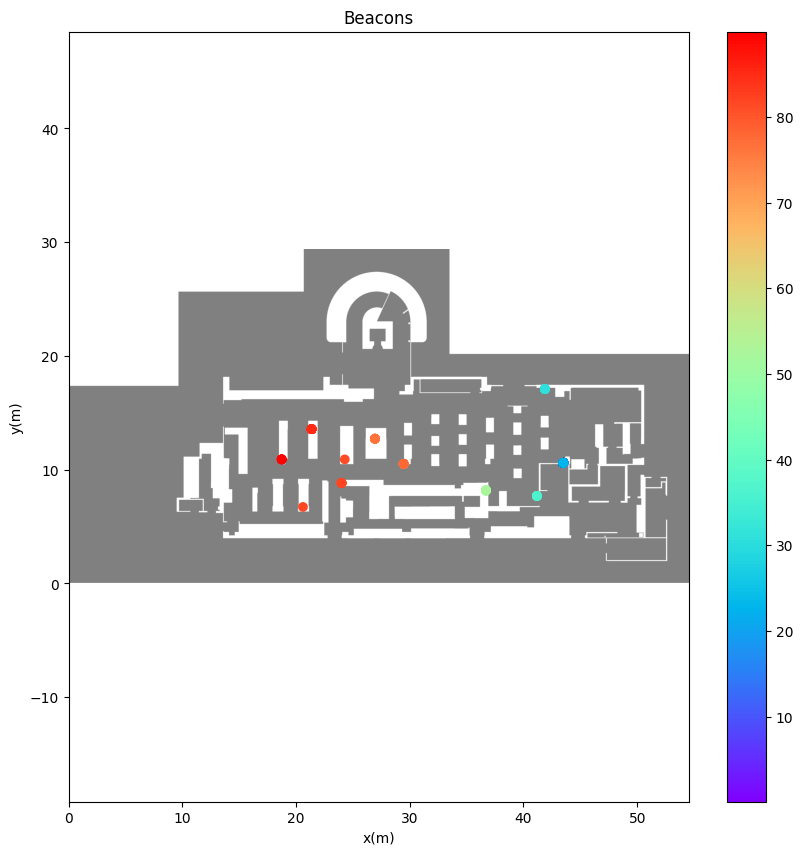

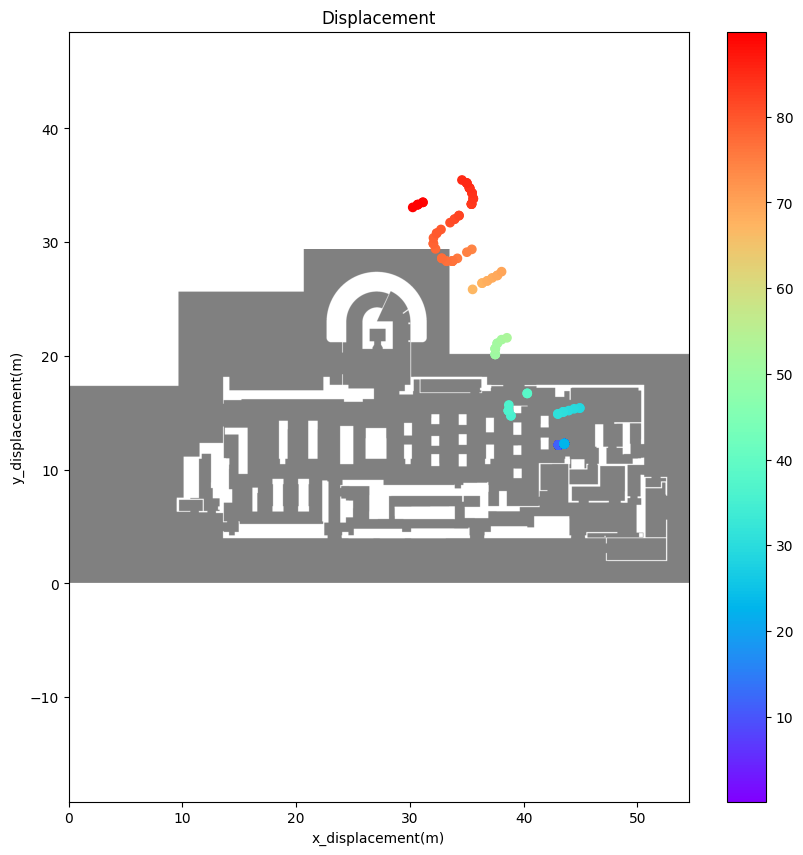

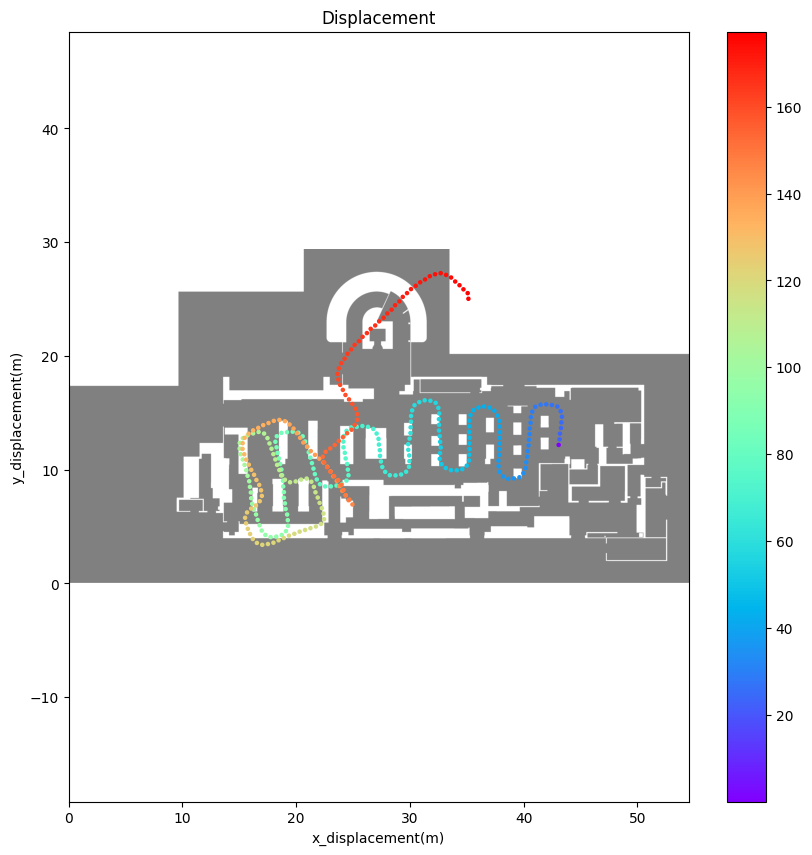

In [30]:

import numpy as np
import pandas as pd


# 軌跡前半の歩行軌跡の座標と強いBLEビーコンの位置座標の距離が最小になる角度を探索
# これは軌跡前半はドリフトが乗りづらいため
#時間全体の中央を変数に入れる

center_of_time = blescans.tail(1)['ts'].values[0]/2

first_half_strong_blescans= estimate.filter_strong_blescans(blescans,center_of_time,-76)
merged_strong_blescans_first_half = estimate.load_beacons_and_merge(BEACON_LIST_PATH, first_half_strong_blescans)


# マップ上にビーコンの位置をプロット
estimate.plot_map(map_dict,floor_name, dx, dy)

plt.colorbar(
    plt.scatter(merged_strong_blescans_first_half.x, merged_strong_blescans_first_half.y, c=merged_strong_blescans_first_half['ts'], cmap="rainbow"))

plt.xlabel("x(m)")
plt.ylabel("y(m)")
plt.title("Beacons")
plt.show()


# 同じ bdaddress, x, y を持つデータをグループ化
merged_df = pd.merge_asof(merged_strong_blescans_first_half, cumulative_displacement_df, on='ts',direction="nearest")
# マップ上にx_displacement,y_displacementとビーコンの位置をプロット
estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(merged_df.x_displacement, merged_df.y_displacement, c=merged_df['ts'], cmap="rainbow"))

# plt.scatter(merged_df.x, merged_df.y, c=merged_df['ts'], cmap="rainbow")

plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()


angle=estimate.search_optimal_angle(cumulative_displacement_df,gt_ref,merged_strong_blescans_first_half)

rotate_by_first_half_angle= pd.DataFrame({
    "ts":angle_in_step_timing.ts,
    "x":angle_in_step_timing.x+angle
})

rotate_by_first_half_angle_displacement = estimate.calculate_cumulative_displacement(
    rotate_by_first_half_angle.ts, rotate_by_first_half_angle['x'], 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]},gt_ref['%time'][0])

estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(rotate_by_first_half_angle_displacement.x_displacement, rotate_by_first_half_angle_displacement.y_displacement,
                c=rotate_by_first_half_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()





[{'drift': -0.01, 'euclidean_distance': 34.66332272373013}, {'drift': -0.009000000000000001, 'euclidean_distance': 33.111962848413555}, {'drift': -0.008000000000000002, 'euclidean_distance': 31.457122856118666}, {'drift': -0.007000000000000003, 'euclidean_distance': 29.70380201068232}, {'drift': -0.006000000000000004, 'euclidean_distance': 27.857435338084336}, {'drift': -0.0050000000000000044, 'euclidean_distance': 25.923892367447927}, {'drift': -0.004000000000000005, 'euclidean_distance': 23.90948571652613}, {'drift': -0.003000000000000006, 'euclidean_distance': 21.820998152891818}, {'drift': -0.002000000000000007, 'euclidean_distance': 19.665744909371615}, {'drift': -0.0010000000000000078, 'euclidean_distance': 17.451706045855406}, {'drift': -8.673617379884035e-18, 'euclidean_distance': 15.187806798792554}, {'drift': 0.0009999999999999905, 'euclidean_distance': 12.884537906649982}, {'drift': 0.0019999999999999896, 'euclidean_distance': 10.555449199347706}, {'drift': 0.002999999999999

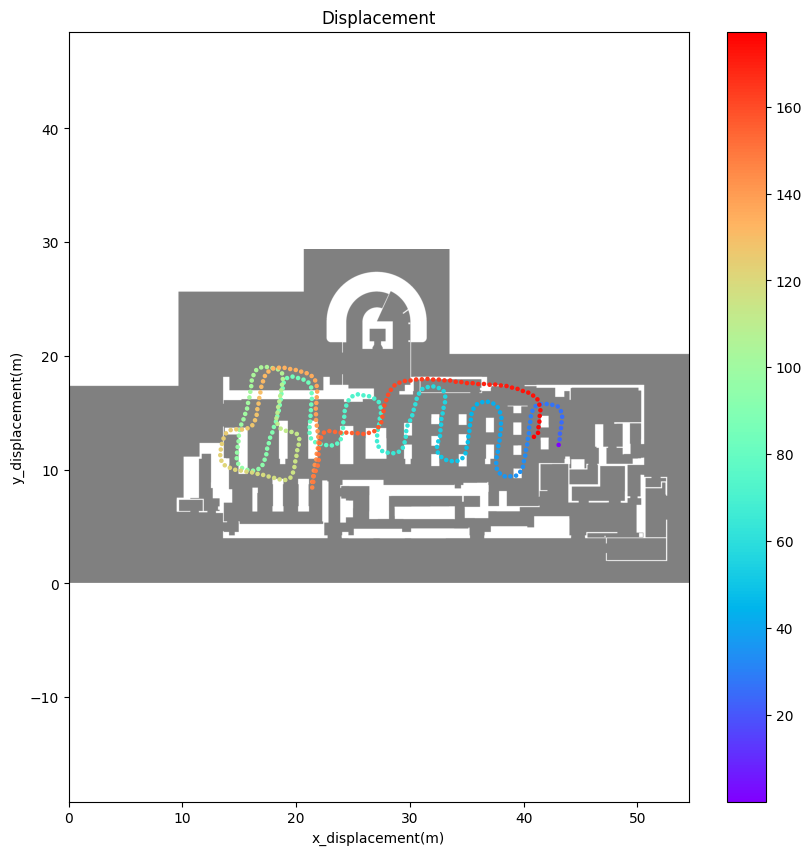

In [31]:
optimal_drift_and_euclidean=estimate.search_optimal_drift_from_angle(rotate_by_first_half_angle,gt_ref)

first_time_remove_drift_angle= pd.DataFrame({
    "ts":rotate_by_first_half_angle.ts,
    "x":rotate_by_first_half_angle.x-optimal_drift_and_euclidean['drift']*(rotate_by_first_half_angle.ts-rotate_by_first_half_angle.ts.iloc[0])
})


first_time_remove_drift_angle_displacement = estimate.calculate_cumulative_displacement(
    first_time_remove_drift_angle.ts, first_time_remove_drift_angle['x'], 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]},gt_ref['%time'][0])

estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(first_time_remove_drift_angle_displacement.x_displacement, first_time_remove_drift_angle_displacement.y_displacement,
                c=first_time_remove_drift_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()



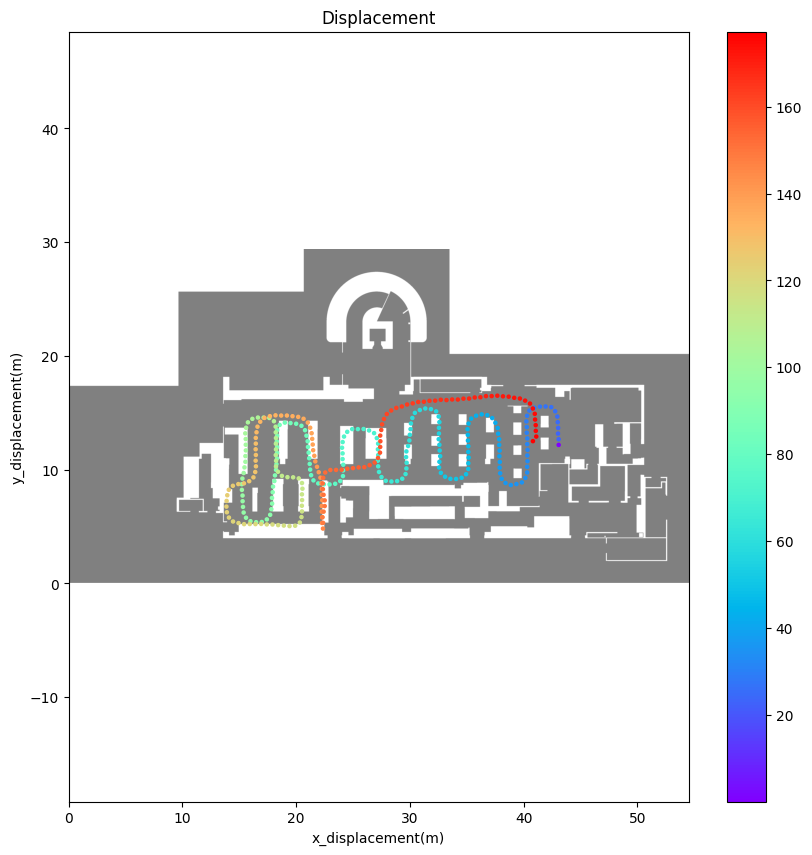

In [32]:
# 軌跡全体の歩行軌跡の座標と強いBLEビーコンの位置座標の距離が最小になる角度を探索見つける
overall_strong_blescans= estimate.filter_strong_blescans(blescans,blescans.tail(1)['ts'].values[0],-76)
merged_strong_blescans_overall = estimate.load_beacons_and_merge(BEACON_LIST_PATH, overall_strong_blescans)

overall_strong_ble_angle = estimate.search_optimal_angle(first_time_remove_drift_angle_displacement,gt_ref,merged_strong_blescans_overall)

rotate_by_overall_strong_ble_angle= pd.DataFrame({
    "ts":first_time_remove_drift_angle.ts,
    "x":first_time_remove_drift_angle.x+overall_strong_ble_angle
})


rotate_by_overall_strong_ble_angle_displacement = estimate.calculate_cumulative_displacement(
    rotate_by_overall_strong_ble_angle.ts, rotate_by_overall_strong_ble_angle['x'], 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]},gt_ref['%time'][0])

estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(rotate_by_overall_strong_ble_angle_displacement.x_displacement, rotate_by_overall_strong_ble_angle_displacement.y_displacement,
                c=rotate_by_overall_strong_ble_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()



[{'drift': -0.01, 'euclidean_distance': 23.906639592211885}, {'drift': -0.009000000000000001, 'euclidean_distance': 21.81925464528549}, {'drift': -0.008000000000000002, 'euclidean_distance': 19.665076771843683}, {'drift': -0.007000000000000003, 'euclidean_distance': 17.452065584469846}, {'drift': -0.006000000000000004, 'euclidean_distance': 15.189118421796735}, {'drift': -0.0050000000000000044, 'euclidean_distance': 12.886683442412513}, {'drift': -0.004000000000000005, 'euclidean_distance': 10.558235851184996}, {'drift': -0.003000000000000006, 'euclidean_distance': 8.22433076129908}, {'drift': -0.002000000000000007, 'euclidean_distance': 5.92613591075938}, {'drift': -0.0010000000000000078, 'euclidean_distance': 3.7856678821281773}, {'drift': -8.673617379884035e-18, 'euclidean_distance': 2.353925208179706}, {'drift': 0.0009999999999999905, 'euclidean_distance': 2.976182482827249}, {'drift': 0.0019999999999999896, 'euclidean_distance': 4.922844234564577}, {'drift': 0.002999999999999989, 

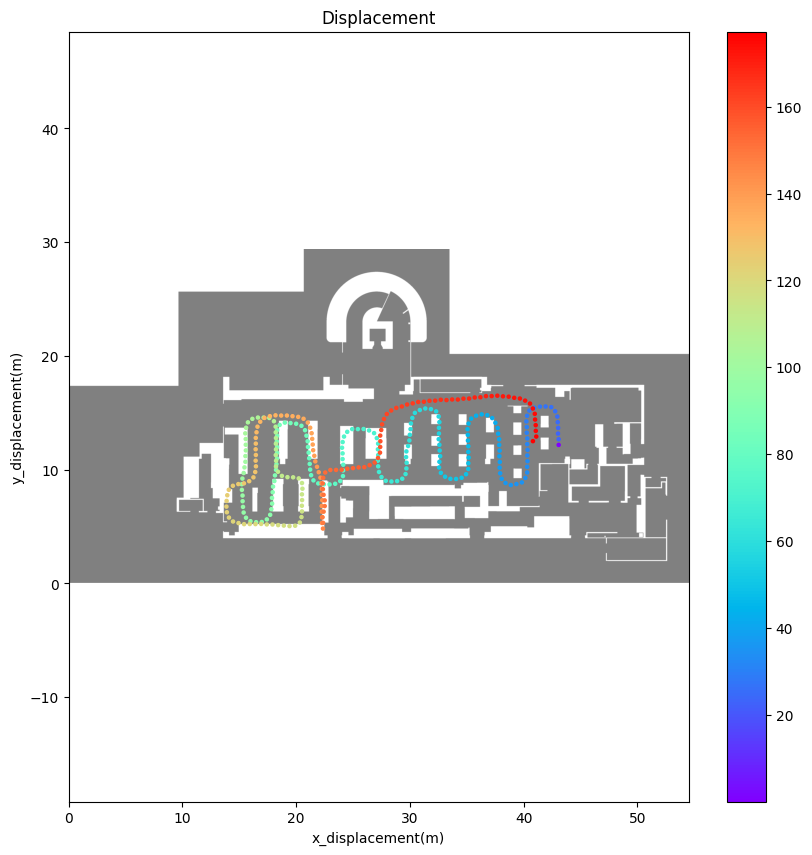

In [33]:



second_optimal_drift_and_euclidean=estimate.search_optimal_drift_from_angle(rotate_by_overall_strong_ble_angle,gt_ref)

second_time_remove_drift_angle= pd.DataFrame({
    "ts":rotate_by_overall_strong_ble_angle.ts,
    "x":rotate_by_overall_strong_ble_angle.x-second_optimal_drift_and_euclidean['drift']*(rotate_by_overall_strong_ble_angle.ts-rotate_by_overall_strong_ble_angle.ts.iloc[0])
})

second_time_remove_drift_angle_displacement = estimate.calculate_cumulative_displacement(
    second_time_remove_drift_angle.ts, second_time_remove_drift_angle['x'], 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]},gt_ref['%time'][0])

estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(second_time_remove_drift_angle_displacement.x_displacement, second_time_remove_drift_angle_displacement.y_displacement,
                c=second_time_remove_drift_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()





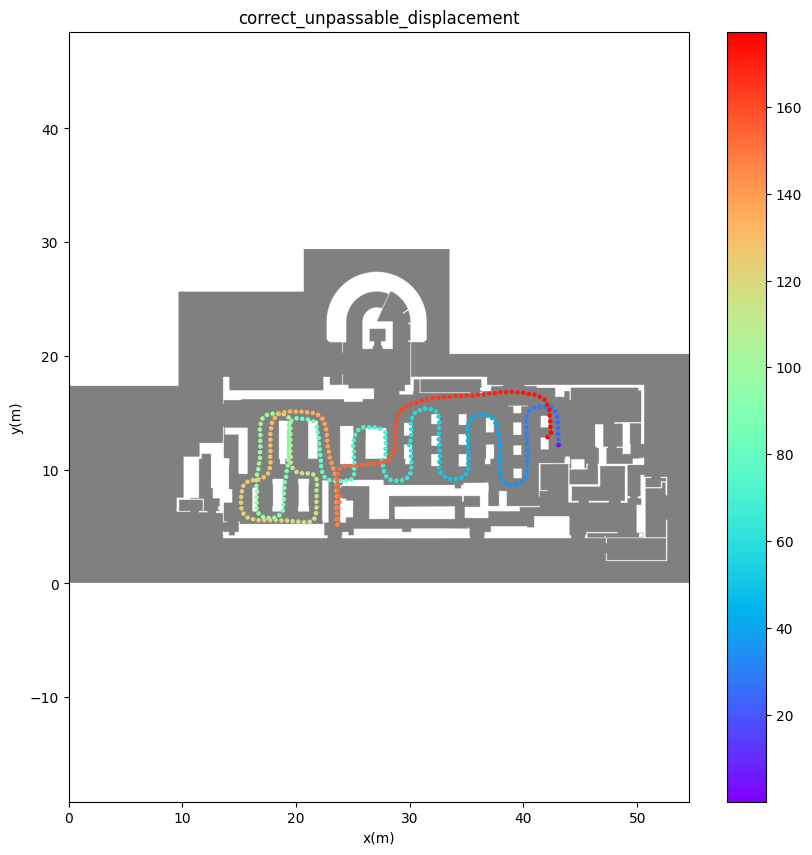

In [34]:

np.set_printoptions(threshold=np.inf)

correct_unpassable_displacement = estimate.correct_unpassable_points(second_time_remove_drift_angle_displacement[second_time_remove_drift_angle_displacement['ts']<180], map_dict, floor_name, dx, dy)

estimate.plot_map(
    map_dict,
    floor_name,
    dx,
    dy,
)

plt.colorbar(
    plt.scatter(
        correct_unpassable_displacement['x_displacement'],
        correct_unpassable_displacement['y_displacement'],
        c=correct_unpassable_displacement['ts'],
        cmap='rainbow',
        s=5
    )
)


plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.title('correct_unpassable_displacement')
plt.show()



output_df = pd.DataFrame({
    'ts': correct_unpassable_displacement['ts'],
    'x': correct_unpassable_displacement['x_displacement'],
    'y': correct_unpassable_displacement['y_displacement'],
    'floor': floor_name
})




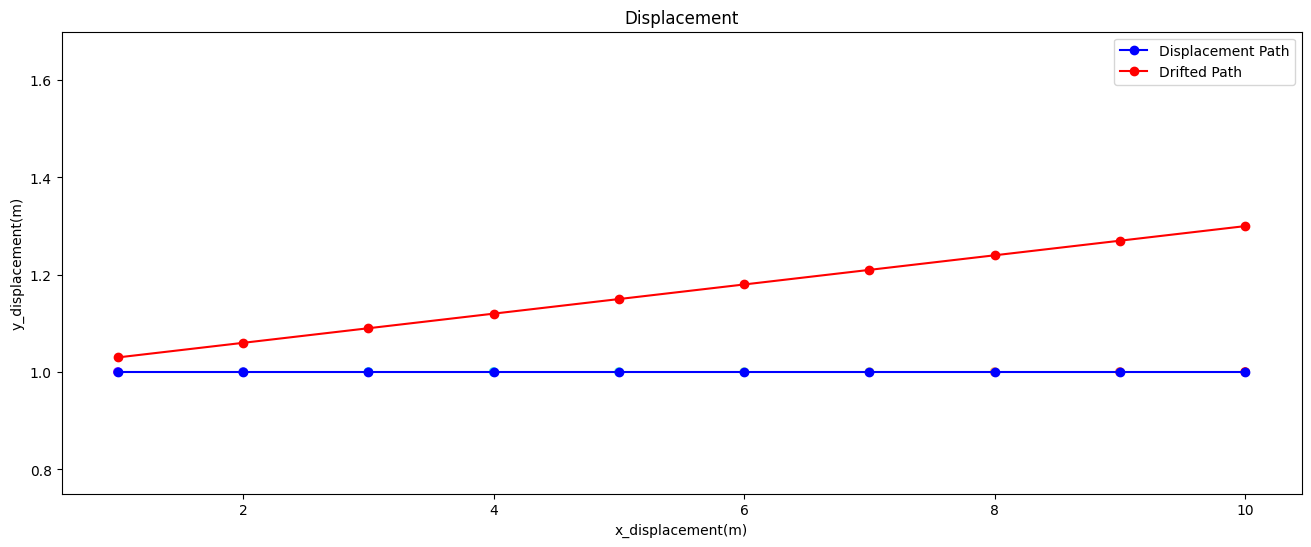

In [35]:

import pandas as pd
import matplotlib.pyplot as plt

displacement_df = pd.DataFrame({
    'x': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'y': [1,1,1,1,1,1,1,1,1,1]
})

# 最後のドリフト値を0.1とする
final_drift_value = 0.3
drifted_y = displacement_df.y + final_drift_value * (displacement_df.x / displacement_df.x.max())

# Plot the line connecting the points
plt.plot(displacement_df.x, displacement_df.y, '-o', label='Displacement Path', color='blue')
plt.plot(displacement_df.x, drifted_y, '-o', label='Drifted Path', color='red')

# y-axis limit
plt.ylim(0.75, 1.7)

# Scatter plot
plt.scatter(displacement_df.x, displacement_df.y, c=displacement_df.index, cmap="rainbow")

plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.legend()
plt.show()



